# The Build Vault Pipeline Demo - Local Version

## Overview

This notebook processes a real podcast episode through the complete pipeline using LOCAL CSV files instead of Supabase:
- Downloads actual audio from YouTube
- Transcribes using AssemblyAI
- Extracts insights with GPT-4.1-mini
- Stores data in local CSV files

In [1]:
# Setup and imports
import os
import sys
import json
import time
import uuid
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown, clear_output

# Configure visualization
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Imports complete")

Imports complete


In [2]:
# Load environment variables
from dotenv import load_dotenv

env_path = os.path.join(os.getcwd(), '.env')
if os.path.exists(env_path):
    load_dotenv(env_path, override=True)
    print(f"Loaded environment variables successfully")
else:
    print(f"No .env file found at {env_path}")

# Verify environment variables
required_vars = [
    'YOUTUBE_API_KEY',
    'ASSEMBLYAI_API_KEY', 
    'OPENAI_API_KEY'
]

all_set = True
for var in required_vars:
    value = os.getenv(var)
    if value:
        print(f"{var}")
    else:
        print(f"{var}: Not set")
        all_set = False

if not all_set:
    print("\nSome environment variables are missing. Check your .env file.")

Loaded environment variables successfully
YOUTUBE_API_KEY
ASSEMBLYAI_API_KEY
OPENAI_API_KEY


In [3]:
# Create local data storage
DATA_DIR = os.path.join(os.getcwd(), 'local_data')
os.makedirs(DATA_DIR, exist_ok=True)

# Initialize CSV files if they don't exist
csv_files = {
    'episodes': os.path.join(DATA_DIR, 'episodes.csv'),
    'segments': os.path.join(DATA_DIR, 'segments.csv'),
    'insights': os.path.join(DATA_DIR, 'insights.csv'),
    'products': os.path.join(DATA_DIR, 'products.csv'),
    'links': os.path.join(DATA_DIR, 'links.csv')
}

# Create empty DataFrames if files don't exist
if not os.path.exists(csv_files['episodes']):
    pd.DataFrame(columns=['id', 'title', 'youtube_video_id', 'youtube_url', 'duration', 
                         'published_at', 'status', 'audio_file_path', 'summary', 
                         'is_processed']).to_csv(csv_files['episodes'], index=False)

if not os.path.exists(csv_files['segments']):
    pd.DataFrame(columns=['id', 'episode_id', 'start_time', 'end_time', 'raw_text', 
                         'display_text', 'speaker', 'confidence', 'duration']).to_csv(csv_files['segments'], index=False)

if not os.path.exists(csv_files['insights']):
    pd.DataFrame(columns=['id', 'episode_id', 'category', 'content', 'confidence_score',
                         'segment_start', 'segment_end']).to_csv(csv_files['insights'], index=False)

if not os.path.exists(csv_files['products']):
    pd.DataFrame(columns=['id', 'name', 'episode_ids', 'mention_count']).to_csv(csv_files['products'], index=False)

if not os.path.exists(csv_files['links']):
    pd.DataFrame(columns=['id', 'episode_id', 'url', 'title', 'description', 
                         'enriched']).to_csv(csv_files['links'], index=False)

print(f"Local data directory created")
print("\nCSV files:")
for name, path in csv_files.items():
    size = os.path.getsize(path)
    print(f"  - {name}: ({size} bytes)")

Local data directory created

CSV files:
  - episodes: (1362 bytes)
  - segments: (21368 bytes)
  - insights: (3102 bytes)
  - products: (2865 bytes)
  - links: (45 bytes)


In [4]:
# Configuration
DEMO_MODE = True
YOUTUBE_URL = "https://www.youtube.com/watch?v=9I_WxAMQ9_0"
SKIP_EXISTING = True
MAX_INSIGHTS = 100
MAX_SEGMENTS = 100

if DEMO_MODE:
    display(HTML("""
    <div style='background: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 5px;'>
        <strong>Demo Mode Active</strong><br>
        <ul style='margin: 5px 0;'>
            <li>Max {} insights</li>
            <li>Max {} segments</li>
        </ul>
    </div>
    """.format(MAX_INSIGHTS, MAX_SEGMENTS)))

## Step 1: Audio Download

In [5]:
# Download audio
import yt_dlp

# Extract video ID
video_id = YOUTUBE_URL.split('v=')[-1].split('&')[0]
audio_dir = os.path.join(os.getcwd(), 'audio_storage')
os.makedirs(audio_dir, exist_ok=True)

# Check if episode exists
episodes_df = pd.read_csv(csv_files['episodes'])
existing = episodes_df[episodes_df['youtube_video_id'] == video_id]

if not existing.empty and SKIP_EXISTING:
    episode_data = existing.iloc[0].to_dict()
    episode_id = episode_data['id']
    print(f"Episode already exists: {episode_data['title']}")
else:
    print(f"Downloading audio from: {YOUTUBE_URL}")
    
    # Download with yt-dlp
    output_path = os.path.join(audio_dir, f'{video_id}.mp3')
    
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'outtmpl': output_path.replace('.mp3', '.%(ext)s'),
        'quiet': True,
        'no_warnings': True,
    }
    
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(YOUTUBE_URL, download=True)
            
        # Create episode record
        episode_id = str(uuid.uuid4())
        episode_data = {
            'id': episode_id,
            'title': info.get('title', 'Unknown Title'),
            'youtube_video_id': video_id,
            'youtube_url': YOUTUBE_URL,
            'duration': info.get('duration', 0),
            'published_at': datetime.now().isoformat(),
            'status': 'downloaded',
            'audio_file_path': output_path,
            'summary': '',
            'is_processed': False
        }
        
        # Save to CSV
        new_episode_df = pd.DataFrame([episode_data])
        episodes_df = pd.concat([episodes_df, new_episode_df], ignore_index=True)
        episodes_df.to_csv(csv_files['episodes'], index=False)
        
        print(f"Downloaded: {episode_data['title']}")
    except Exception as e:
        print(f"Download error: {e}")
        episode_id = None

# Display episode info
if 'episode_id' in locals() and episode_id:
    display(HTML(f"""
    <div style='background: #f8f9fa; padding: 20px; border-radius: 10px; margin: 10px 0;'>
        <h4 style='margin: 0 0 10px 0;'>Episode Information</h4>
        <p><strong>Title:</strong> {episode_data['title']}</p>
        <p><strong>YouTube ID:</strong> {video_id}</p>
        <p><strong>Duration:</strong> {episode_data['duration']} seconds</p>
        <p><strong>Status:</strong> {episode_data['status']}</p>
    </div>
    """))
else:
    print("Failed to download or load episode")

Episode already exists: The Build - Agents as MCP Tools


## Step 2: Transcription

Success: Found existing transcription with 19 segments


### Transcript Sample

,start_time,speaker,display_text
0,0.16,Speaker A,Did you just say that applications as agents?
1,3.60,Speaker B,"Like yeah, it's kind of like an agent kind of ..."
2,36.38,Speaker A,"Tom, I mentioned to you I like to demo these L..."
3,74.38,Speaker B,"And Tool Swarm transfer to SQL Agent. Okay, we..."
4,84.02,Speaker A,"Yeah, so it called my tool Swarm as a tool. So..."


### Full Transcript

*... and 14 more segments*

### Speaker Statistics

  Speaker A: 409.4 seconds (6.8 minutes)
  Speaker B: 314.5 seconds (5.2 minutes)


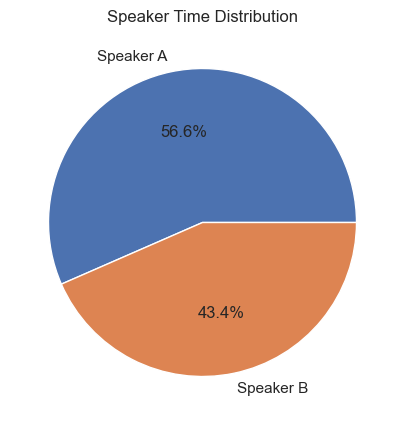

In [6]:
# Transcribe audio
import assemblyai as aai

if 'episode_id' not in locals():
    print("Error: Please run the Audio Download step first")
    segments = []
elif episode_id:
    # Check existing segments
    segments_df = pd.read_csv(csv_files['segments'])
    existing_segments = segments_df[segments_df['episode_id'] == episode_id]
    
    if not existing_segments.empty and SKIP_EXISTING:
        print(f"Success: Found existing transcription with {len(existing_segments)} segments")
        segments = existing_segments.to_dict('records')
    else:
        print("Starting transcription with AssemblyAI...")
        
        # Configure AssemblyAI
        aai.settings.api_key = os.getenv('ASSEMBLYAI_API_KEY')
        
        audio_path = episode_data['audio_file_path']
        if os.path.exists(audio_path):
            try:
                # Transcribe
                transcriber = aai.Transcriber()
                config = aai.TranscriptionConfig(
                    speaker_labels=True,
                    speakers_expected=2
                )
                
                print("Uploading and transcribing (this may take a few minutes)...")
                transcript = transcriber.transcribe(audio_path, config=config)
                
                if transcript.status == aai.TranscriptStatus.error:
                    print(f"Error: Transcription error: {transcript.error}")
                    segments = []
                else:
                    # Process utterances
                    segments = []
                    for utterance in transcript.utterances:
                        segment = {
                            'id': str(uuid.uuid4()),
                            'episode_id': episode_id,
                            'start_time': utterance.start / 1000,
                            'end_time': utterance.end / 1000,
                            'raw_text': utterance.text,
                            'display_text': utterance.text,
                            'speaker': f"Speaker {utterance.speaker}",
                            'confidence': getattr(utterance, 'confidence', 0.9),
                            'duration': (utterance.end - utterance.start) / 1000
                        }
                        segments.append(segment)
                    
                    # Save to CSV
                    if segments:
                        new_segments_df = pd.DataFrame(segments)
                        segments_df = pd.concat([segments_df, new_segments_df], ignore_index=True)
                        segments_df.to_csv(csv_files['segments'], index=False)
                        print(f"Success: Transcription complete! {len(segments)} segments saved")
                    
            except Exception as e:
                print(f"Error: Transcription error: {e}")
                segments = []
        else:
            print(f"Error: Audio file not found: {audio_path}")
            segments = []
else:
    segments = []

# Display transcript
if segments:
    # Apply demo limit
    display_segments = segments[:MAX_SEGMENTS] if DEMO_MODE else segments
    
    if len(display_segments) < len(segments):
        print(f"\nDemo mode: Showing first {MAX_SEGMENTS} of {len(segments)} segments")
    
    # Create DataFrame for display
    df_display = pd.DataFrame(display_segments)
    
    # Show sample
    display(Markdown("### Transcript Sample"))
    display(df_display[['start_time', 'speaker', 'display_text']].head())
    
    # Show full transcript nicely
    display(Markdown("### Full Transcript"))
    for i, segment in enumerate(display_segments):
        if i >= 5:
            display(Markdown(f"*... and {len(segments) - 5} more segments*"))
            break
        
        display(HTML(f"""
        <div style='margin: 10px 0; padding: 10px; background: #f5f5f5; border-left: 3px solid #2196F3;'>
            <strong>{segment['speaker']}</strong> <span style='color: #666; font-size: 12px;'>({segment['start_time']:.1f}s)</span><br>
            {segment['display_text']}
        </div>
        """))
    
    # Speaker statistics
    df_stats = pd.DataFrame(segments)
    speaker_stats = df_stats.groupby('speaker')['duration'].sum()
    
    display(Markdown("### Speaker Statistics"))
    for speaker, duration in speaker_stats.items():
        print(f"  {speaker}: {duration:.1f} seconds ({duration/60:.1f} minutes)")
    
    # Pie chart
    plt.figure(figsize=(8, 5))
    plt.pie(speaker_stats.values, labels=speaker_stats.index, autopct='%1.1f%%')
    plt.title('Speaker Time Distribution')
    plt.show()
else:
    print("\nWarning: No segments to display")

In [7]:
# Generate summary
from openai import OpenAI

# Check if required variables exist
if 'episode_id' not in locals():
    print("Error: Please run the Audio Download step first")
elif 'segments' not in locals():
    print("Error: Please run the Transcription step first")
elif episode_id and segments:
    # Check if summary exists
    episodes_df = pd.read_csv(csv_files['episodes'])
    episode_row = episodes_df[episodes_df['id'] == episode_id].iloc[0]
    
    # Handle potential NaN or empty values
    existing_summary = episode_row.get('summary', '')
    if pd.isna(existing_summary) or existing_summary == '':
        existing_summary = None
    else:
        existing_summary = str(existing_summary)
    
    if existing_summary and SKIP_EXISTING:
        print("Success: Summary already exists")
        summary = existing_summary
    else:
        print("Generating episode summary with gpt-4.1-mini...")
        
        client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
        
        # Combine transcript (limit for demo)
        transcript_segments = segments[:20] if DEMO_MODE else segments[:50]
        transcript = "\n".join([f"{s['speaker']}: {s['display_text']}" for s in transcript_segments])
        
        try:
            response = client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[
                    {"role": "system", "content": "You are a podcast summarizer. Create a concise, engaging summary."},
                    {"role": "user", "content": f"Summarize this podcast transcript:\n\n{transcript[:4000]}"}
                ],
                max_tokens=300
            )
            
            summary = response.choices[0].message.content
            
            # Update CSV
            episodes_df.loc[episodes_df['id'] == episode_id, 'summary'] = summary
            episodes_df.to_csv(csv_files['episodes'], index=False)
            
            print("Success: Summary generated!")
            
        except Exception as e:
            print(f"Error: Summary error: {e}")
            summary = "Error generating summary"
    
    # Display summary
    if 'summary' in locals() and summary:
        display(HTML(f"""
        <div style='background: #f0f8ff; padding: 20px; border-radius: 10px; border: 2px solid #4caf50;'>
            <h4 style='color: #2e7d32; margin-top: 0;'>Episode Summary</h4>
            <p style='line-height: 1.6;'>{summary}</p>
            <p style='color: #666; font-size: 14px; margin-top: 15px;'>
                <strong>Word count:</strong> {len(str(summary).split())} words
            </p>
        </div>
        """))
else:
    print("Warning: No episode or segments available to summarize")

Success: Summary already exists


## Step 3: Generate Summary

Success: Found 9 existing insights


### Extracted Insights


Insights by category:
   Technical Insights: 4
   Frameworks & Exercises: 3
   Products: 1
   Business Ideas: 1


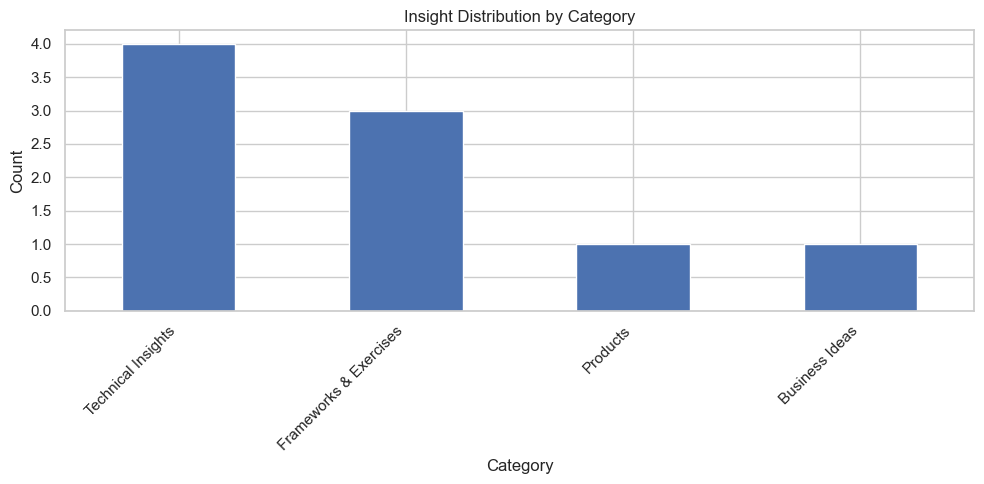

In [8]:
# Extract insights - Enhanced with better debugging
from openai import OpenAI
import traceback

# Check if required variables exist
if 'episode_id' not in locals():
    print("Error: Please run the Audio Download step first")
elif 'segments' not in locals() or not segments:
    print("Error: Please run the Transcription step first")
elif episode_id and segments:
    # Check existing insights
    insights_df = pd.read_csv(csv_files['insights'])
    existing_insights = insights_df[insights_df['episode_id'] == episode_id]
    
    if not existing_insights.empty and SKIP_EXISTING:
        print(f"Success: Found {len(existing_insights)} existing insights")
        insights = existing_insights.to_dict('records')
    else:
        print("Extracting insights with GPT-4...")
        print(f"Processing {len(segments)} segments in batches...")
        
        client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
        insights = []
        
        # Process in batches
        batch_size = 10
        max_batches = 3 if DEMO_MODE else 10
        
        for i in range(0, min(len(segments), batch_size * max_batches), batch_size):
            batch = segments[i:i+batch_size]
            batch_num = i//batch_size + 1
            print(f"\nProcessing batch {batch_num}/{min(len(segments)//batch_size + 1, max_batches)}...")
            
            # Combine transcript
            transcript = "\n".join([f"{s['speaker']}: {s['display_text']}" for s in batch])
            print(f"   Transcript length: {len(transcript)} chars")
            
            try:
                print("   Calling gpt-4.1-mini...")
                response = client.chat.completions.create(
                    model="gpt-4.1-mini",
                    messages=[
                        {"role": "system", "content": """You are analyzing a podcast transcript. Extract key insights and return them as JSON.
                        
                        You must return a valid JSON object with an 'insights' array. Each insight should have:
                        - category: one of "Frameworks & Exercises", "Products", "Business Ideas", "Technical Insights"
                        - content: the insight text (1-2 clear sentences describing the insight)
                        - confidence: confidence score between 0.0 and 1.0
                        
                        Focus on:
                        - Key concepts or frameworks discussed
                        - Product mentions and their use cases
                        - Business ideas or opportunities mentioned
                        - Technical insights or best practices
                        
                        Example response:
                        {
                          "insights": [
                            {
                              "category": "Products",
                              "content": "The speakers discuss OpenAI's new ChatGPT connectors which enable read-only access to external data sources.",
                              "confidence": 0.9
                            },
                            {
                              "category": "Technical Insights",
                              "content": "The connectors are designed to be search-only to better serve enterprise security requirements.",
                              "confidence": 0.85
                            }
                          ]
                        }
                        
                        Return ONLY the JSON object, no other text."""},
                        {"role": "user", "content": f"Extract insights from this podcast segment:\n\n{transcript[:3500]}"}
                    ],
                    temperature=0.2
                )
                
                print("   Got response from gpt-4.1-mini")
                response_text = response.choices[0].message.content
                print(f"   Response preview: {response_text[:200]}...")
                
                insights_data = json.loads(response_text)
                batch_insights = insights_data.get('insights', [])
                print(f"   Success: Found {len(batch_insights)} insights in batch {batch_num}")
                
                # Add insights with proper metadata
                for insight in batch_insights:
                    if insight.get('content'):  # Only add if content exists
                        insights.append({
                            'id': str(uuid.uuid4()),
                            'episode_id': episode_id,
                            'category': insight.get('category', 'Business Ideas'),
                            'content': insight.get('content', ''),
                            'confidence_score': float(insight.get('confidence', 0.8)),
                            'segment_start': batch[0]['start_time'],
                            'segment_end': batch[-1]['end_time']
                        })
                        
            except json.JSONDecodeError as e:
                print(f"   Warning: JSON parsing error in batch {batch_num}: {e}")
                print(f"   Response was: {response_text[:500]}...")
            except Exception as e:
                print(f"   Warning: Error in batch {batch_num}: {type(e).__name__}: {e}")
                traceback.print_exc()
        
        print(f"\nTotal insights extracted: {len(insights)}")
        
        # Save insights
        if insights:
            new_insights_df = pd.DataFrame(insights)
            # Append to existing insights
            if not insights_df.empty:
                insights_df = pd.concat([insights_df, new_insights_df], ignore_index=True)
            else:
                insights_df = new_insights_df
            insights_df.to_csv(csv_files['insights'], index=False)
            print(f"Success: Saved {len(insights)} insights to CSV!")
            
            # Show sample of saved data
            print("\nSample of saved insights:")
            for i, insight in enumerate(insights[:3]):
                print(f"   {i+1}. [{insight['category']}] {insight['content'][:100]}...")
        else:
            print("Warning: No insights were extracted. This could be due to:")
            print("   - API key issues")
            print("   - Rate limiting")
            print("   - Transcript content not suitable for insights")
            print("\nDebug info:")
            print(f"   - Segments available: {len(segments)}")
            print(f"   - OpenAI API key: {'Set' if os.getenv('OPENAI_API_KEY') else 'Not set'}")
    
    # Display insights
    if 'insights' in locals() and insights:
        display_insights = insights[:MAX_INSIGHTS] if DEMO_MODE else insights
        
        display(Markdown("### Extracted Insights"))
        
        # Group by category
        df_insights = pd.DataFrame(display_insights)
        categories = df_insights['category'].value_counts()
        
        print(f"\nInsights by category:")
        for category, count in categories.items():
            print(f"   {category}: {count}")
        
        # Display insights by category
        for category, count in categories.items():
            display(HTML(f"<h4>{category} ({count})</h4>"))
            
            cat_insights = df_insights[df_insights['category'] == category].head(3)
            for _, insight in cat_insights.iterrows():
                display(HTML(f"""
                <div style='background: #f5f5f5; padding: 10px; margin: 5px 0; 
                            border-left: 3px solid #2196F3; border-radius: 5px;'>
                    <p style='margin: 0;'>{insight['content']}</p>
                    <small style='color: #666;'>Confidence: {insight['confidence_score']:.2f}</small>
                </div>
                """))
        
        # Visualize distribution
        if not categories.empty:
            plt.figure(figsize=(10, 5))
            categories.plot(kind='bar')
            plt.title('Insight Distribution by Category')
            plt.xlabel('Category')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("\nNo insights to display. Check the debug output above.")
else:
    print("Warning: Missing required data for insight extraction")

## Step 4: Extract Insights

Extracting products from episode content...
Searching for 501 known products...

Checking insights for product mentions...

Checking 19 transcript segments...

Found 80 total product mentions
30 unique products found
Success: Updated 30 existing products

Success: Products extraction complete!
   - Total unique products: 30
   - Total mentions: 80


### Products Mentioned

#### Top Products by Mentions:

#### Product Mention Distribution:

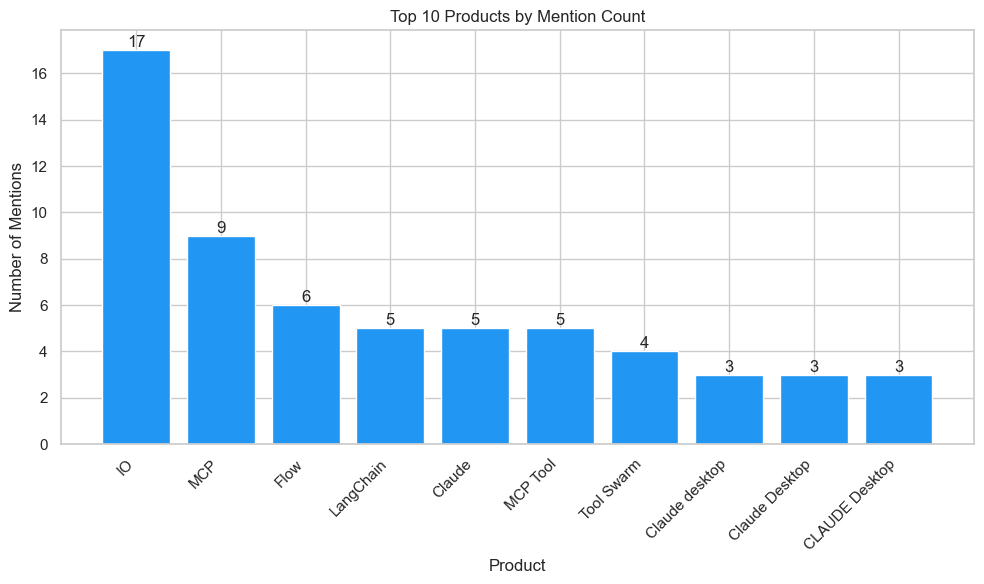

In [9]:
# Extract products mentioned - Enhanced version
print("Extracting products from episode content...")

# Check if we have data to work with
has_insights = 'insights' in locals() and insights
has_segments = 'segments' in locals() and segments

if not has_segments:
    print("Error: No segments available. Please run transcription first.")
else:
    # Read existing products
    products_df = pd.read_csv(csv_files['products'])
    products_found = []
    
    # Comprehensive list of products from The Build Vault database
    known_products = [
        '16-camera Setup', '16-Camera Setup', '2.5 model', '3D Rendering Tools', '3js', '808 Protocol',
        '8-way Inspector Tool', 'A2A', 'A2A Agent Card', 'A2A Demo Web App', 'A2A Protocol',
        'A2A Protocol & ADK Kit', 'A2A Protocol Validator', 'A2A Protocol Wrapping', 'ABK Agent',
        'Ableton Live', 'Ableton MCP', 'ADA Development Website', 'ADK Kit', 'Advanced LLM Tooling',
        'Agent Card Interface', 'Agent Development Studio', 'Agent Development Tool', 'agent email manager',
        'Agent Email Manager', 'Agentic coding tools', 'Agentic Coding Tools', 'Agent Inbox', 'AgentInbox',
        'Agents SDK', 'Agent-to-Agent (A2A) Protocol', 'Age of Experience', 'Age of Experience Paper',
        'AI Chat Integration', 'AI SDK', 'AI Visualization Project', 'Alexa Voice Assistant', 'AlexNet',
        'Amazon S3 Storage', 'Ambient Agent Showcases', 'Amy Math Dataset', 'Android', 'Android devices',
        'Android Devices', 'Anthropic', 'Anthropic Computer Use', 'Anthropic Data Notebook',
        'Anthropic Economic Index', 'Anthropic Integration', 'Anthropic Integration Compatibility',
        'Anthropic Integrations', 'Anthropic MCP Server', 'Anthropic System Prompt', 'Apple AR Wearables',
        'Apple Devices', 'Arcade', 'Arcade Connector', 'Arcade.dev', 'Arcade Platform', 'Arcade Server',
        'Arcade Server Demo', "Arcade's MCP", 'ARC Prize Test Access', 'Audio AI Model',
        'Augmented Reality App', 'Augmented Reality Glasses', 'Authentication Components',
        'Auto-discover MCP Servers', 'AWE AR Conference', 'Azure AI Foundry', 'Azure Debugging Features',
        'Bing API search', 'Bing Search API', 'BlackRock LangChain Solution', 'Brave AI Leo',
        'Browser Info Saving', 'Build Demo Location', 'Builder Fusion', 'Build Supervisor',
        'Build Supervisor Tool', 'Build Vault Website', 'ByteDance video model', 'Cerebras inference approach',
        'Cerebras Inference Approach', 'Chat GPT', 'ChatGPT', 'ChatGPT connectors', 'ChatGPT Connectors',
        'ChatGPT Desktop', 'ChatGPT Read-Only Connectors', 'Claude', 'Claude 3.7', 'Claude 4', 'Claude4',
        'Claude 4 AI System', 'Claude4 Premium Upgrade', 'claude.ai', 'Claude AI', 'Claude AI Model',
        'Claude code', 'Claude Code', 'Claude Code Claim', 'Claude Code & Codex', 'Claude desktop',
        'Claude Desktop', 'CLAUDE Desktop', 'CLAUDE Desktop Extensions', 'Claude Desktop Extensions (.dxt)',
        'Claude Four', 'Claude Haiku', 'Claude Haiku Model', 'Claude MD File', 'Claude Parallel Tools',
        'Claude System Card', 'Claude Web', 'Claude Web Search Integration', 'Clients Auto-Discovery',
        'Cline AI Autonomous Coding Agent for VS Code', 'Cloud Code', 'Cloudflare',
        'Cloudflare Container Integration', 'Cloudflare Containers', 'Cloudflare Container Service',
        'Cloudflare D1 Database', 'Cloudflare native database access', 'Cloudflare Under Attack Mode',
        'Cloudflare Workers', 'Codex', 'Codex GitHub integration', 'Coding Prompt Slide', 'Colab Notebook',
        'Comfy UI', 'ComfyUI', 'Complete Bot Blocking', 'Computer Use', 'Containerized Environments',
        'Copilot Studio', 'Creative Tooling Project', 'Cursor', 'Custom Tools & Templates',
        'Custom Tool Templates', 'D3', 'D3 Charting Library', 'Daytona', 'Daytona equivalent container',
        'Daytona Sandbox Environment', 'Daytona Website', 'DeepMind Age of Experience', 'Deep Research Agent',
        'Deep Research Credits', 'Deep SEQ', 'Deep Seq Model', 'Deep Seq Reasoning Model', 'Deep Wiki',
        'DeepWiki', 'Deep Wiki Agent', 'DeepWiki MCP Endpoint', 'Deep Winkey', 'Developer Package Manager',
        'Devon Slack Integration', 'Diffusion Models', 'Doc ETL', 'DocETL', 'Docker',
        'Docker Container Image', 'Document ETL Module', 'Epoch AI Model Tracker', 'Evals', 'Figma',
        'First Audio-Enabled AI Model', 'Flora', 'Flora Fauna', 'Flora Software', 'Flora tool', 'Flow',
        'Foundry', 'Foundry Ecosystem', 'Gaming Headset', 'Gaming Headsets', 'Gaussian splatting',
        'Gaussian Splatting Approach', 'Gemini Deep Research Agent', 'Gemini diffusion model',
        'Gemma 3N Model', 'Generative UI Example', 'Genetic Penetration Testing Agent Swarm',
        'Gina AI Endpoint', 'Gina AI Website API', 'GitHub', 'GitHub Medical Agent',
        'GitHub Project Management', 'Glean Enterprise Search', 'Gmail', 'Google A2A Protocol',
        'Google AI Mode', 'Google CLI Tool', 'Google Cloud Platform', 'Google Colab Notebook',
        'Google Flow', 'Google Gemini Agent', 'Google Gemini CLI', 'Google Vertex MedAI Model',
        'Google Video Conferencing', 'Google X xr Glasses', 'Google X XR Glasses', 'Google X XR Platform',
        'GPT-3', 'GPUs', 'Graph Chat Switch', 'Grok', 'Grok 4', 'Grok 4 Model', 'Grok LPU Architecture',
        'Groq Cloud', 'GUI Configuration', 'Hailuo 02', 'HOA Repository Samples', 'Hosted Cloud Option',
        'Hosted Demo Version', 'Hosted Experimentation Version', 'Hosted MCP Connectors', 'Hosted MCP Servers',
        'Hosted OAP Demo', 'Hosted Version Demo', 'Hosted Version Sandbox', 'Hugging Face Medical Sets',
        "Humanity's Last Exam", 'Inception Labs Research', 'Incline 2.5 Experimental', 'IO', 'IO Device',
        'iOS Voice App', 'Jules Autonomous AI Coding Agent', 'Jules Coding Engine', "Karpathy's LLM Tutorial",
        "Karpathy's LLM Video", 'Kinesi', 'Klein AI System', 'Knowledge base', 'KWAG Model', 'Lance DB',
        'LanceDB', 'Landgraph Platform', 'LangChain', 'LangChain Framework', 'LangChain & LangGraph',
        'LangChain Library', 'LangChain Memory Package', 'LangChain Open Agent', 'LangChain Open Agent platform',
        'LangChain Open Agent Platform', 'LangChain Open-Source Project', 'LangChain Platform',
        'LangChain plugin', "LangChain's Evals framework", "LangChain's graphs", 'Langgraph', 'LangGraph',
        'Langgraph agent', 'Langgraph Agent', 'LangGraph Agent Engine', 'Langgraph Agents',
        'Langgraph Cloud', 'Lang Graph Cloud', 'LangGraph Cloud', 'Langgraph Cloud Assistants',
        'Lang Graph dev', 'Langgraph Front', 'LangGraph Platform', 'Langgraph Platform Cloud',
        'LangGraph Starter Kit', 'Langgraph Studio', 'LangGraph Studio', 'LangLangCh', 'Langmem',
        'LangMem', 'Langmen', 'Langmen Package', 'Langraph Cloud', 'Langraph Platform', 'Langsmith',
        'LangSmith', 'LangSmith Observability', 'LangSmith Platform', 'Langsmith Tracing Tool',
        'Langsmith view', 'Langsmith View', 'Language Front', 'Letta', 'Letta AI Product', 'Linear',
        'Linear agents', 'Linear Agents', 'Linear Task Manager', 'Live 12', 'LLM Powered Autonomous Agents',
        'Local Development Environment', 'Maidxo Diagnostic Agent', 'Manus', 'Manus AI Tool',
        'Max for Live', 'MCP', 'MCP Agents', 'MCP and A2A agent-to-agent protocols',
        'MCP and A2A Protocols', 'MCP Demos', 'MCP Integrator Toolkit', '[mcp]Lab', 'MCP + OAP Orchestrator',
        'MCP platform', 'MCP Platform', 'MCP registry', 'MCP Registry', 'MCP Server',
        'MCP Server Connectors', 'MCP servers', 'MCP Servers', 'MCP Server Tool', 'MCP Streamable HTTP',
        'MCP Technology', 'MCP Tool', 'Mem0', 'MEM0 Memory Module', 'Memos', 'memos paper', 'Memos paper',
        'Memos Paper', 'Memos Project', 'Mercury', 'Meta AR Devices', 'Microsoft Cloud Platform (MCP)',
        'Microsoft Enterprise Connectors', 'Microsoft Initial Connectors', 'Microsoft Power Platform',
        "Microsoft's OpenAI Stake", 'Million-Token Context Model', 'Minimax', 'Minimax video model',
        'ML Integration in Agents', 'MongoDB', 'Multi-angle Camera Capture', 'Multi-Angle Footage Rendering',
        'Multi-Product Tool Integration', 'NAICS Raw Data', 'NCP Collaboration Framework',
        'NEJM Open Datasets', 'Neo4J', 'Neo4J Graph Database', 'neural graph', 'Neural Graph Tool',
        'Neurop', 'Next.js Hosting Platform', 'Nvidia Proprietary Models', "Nvidia's Proprietary Models",
        'o3', 'O3', 'O3 Agent', 'O3 LLM Core Model', 'O3 model', 'O3 preview', 'Open Agent platform',
        'Open Agent Platform', 'OpenAgent Platform', 'Open Agent Platform (OAP)', 'OpenAI',
        'OpenAI Agents SDK', 'OpenAI Codex', 'OpenAI customer service demo', 'OpenAI desktop app',
        'OpenAI Embeddings', 'OpenAI embeddings model', 'OpenAI Embeddings Model', 'OpenAI Evaluations',
        'OpenAI GPT-3', 'OpenAI Interface', 'OpenAI MCP', 'OpenAI Memory Feature',
        'OpenAI Microsoft Connectors', 'OpenAI o3', 'OpenAI Real-Time API', 'OpenAI Service Demo',
        "OpenAI's MCP", "OpenAI's SDK", 'OpenAI Swarm Paper', 'OpenAI tools', 'Open Deep Wiki',
        'OpenEvidence', 'Open Router', 'OpenRouter', 'Open Source Agent Graph', 'Open Source Culture Book',
        'Open Source Sandboxes', 'Operator', 'Operator feature', 'Orange Pi', 'Orange PI',
        'Orange PI SBC', 'Orange Pi with NPU', 'Ortho Authentication Tooling', 'Paid demo instance',
        'Perplexity Browser', 'Perplexity Labs', 'Pliny GitHub Repo', 'Pliny GitHub Repository',
        'Pliny the Elder GitHub Repo', 'Pliny the Elder Repo', 'Pliny the Prompter', 'Power Platform',
        'PowerPoint', 'Pulse MCP', 'Pulse MCP API', 'Pulse MCP Marketplace', 'Quad Four', 'Quinn 2',
        'Qwen3', 'Raspberry Pi Pico', 'React Three Fiber', 'Readable AI Tool Version',
        'Read Wiki Structure Tool', 'Real-Environment Flight Tech', 'Real-time Stable Diffusion',
        'Replicate', 'Replit', 'Replit V2 IDE', 'Revenue and Employees Data', 'Revenue per Employee',
        'Riverside', 'Riverside.fm', 'Riverside Tool', 'RL Datasets on Hugging Face', 'Router',
        'Router Leaderboard Feature', 'S3', 'Scrappy Bar API', 'Scrapybara', 'search connector',
        'Search Connector', 'Second Opinion OAP Supervisor', 'Seed Dance 1.0', 'Self-Hosted Version',
        'Slack', 'Snap Glasses Infrared', 'Snap Glasses Infrared Sensors', "Snap's glasses",
        'Snap Smart Glasses', 'Social Media Platforms', 'Sora', 'Sora Editing Tool', 'Sora Video Editor',
        'SQL Agent', 'Stable Diffusion', 'Stripe Developer Books', 'Studio Environment', 'Supabase',
        'Supabase Integration', 'Supabase Integration Customization', 'Supervisor View', 'Surface Pro',
        'Swift Voice Agent Implementation', 'Synth ID', 'Tableau dashboard', 'Tableau Dashboard',
        'Tavily', 'Tavily Search API', 'Tavoli Search API', 'Three.js', 'Tool Information UI',
        'Tool Suite Integration', 'Tool Swarm', 'Tool Swarm Agent', 'UI Capture Interaction',
        'Universal Tool Server', 'Unreal Engine', 'Unreal Engine toolkit', 'V0 Agent', 'v0.dev',
        'v0.dev Agent', 'V0 portal', 'V0 Portal', 'V2', 'Vector Store', 'Vector Store Interaction',
        'Vending Bench', 'VEO', 'VEO 3', 'VEO video model', 'Vercel', 'Vercel Platform',
        'Vertex Monitoring Tools', 'Video Generation Tool', 'Virtual Desktop Tools', 'VO2 Agent',
        'VS Code', 'Website Toolkit', 'WebSockets', 'WebSockets Technology', 'Windows 95', 'Xcode',
        'Xcode AI Enhancements', 'Xcode AI Integration', 'Zapier Integration'
    ]
    
    print(f"Searching for {len(known_products)} known products...")
    
    # Extract from insights if available
    if has_insights:
        print("\nChecking insights for product mentions...")
        for insight in insights:
            content = insight['content'].lower()
            
            for product in known_products:
                if product.lower() in content:
                    products_found.append({
                        'name': product,
                        'episode_id': episode_id,
                        'mentioned_in': 'insight',
                        'context': insight['content'][:200]
                    })
    
    # Extract from transcript segments
    print(f"\nChecking {min(len(segments), 50)} transcript segments...")
    for i, segment in enumerate(segments[:50]):  # Limit to first 50 segments for demo
        content = segment['display_text'].lower()
        
        for product in known_products:
            if product.lower() in content:
                products_found.append({
                    'name': product,
                    'episode_id': episode_id,
                    'mentioned_in': 'transcript',
                    'context': segment['display_text'][:200]
                })
    
    print(f"\nFound {len(products_found)} total product mentions")
    
    # Deduplicate and count mentions
    product_counts = {}
    for p in products_found:
        name = p['name']
        if name not in product_counts:
            product_counts[name] = {
                'count': 0,
                'episode_ids': [],
                'contexts': []
            }
        product_counts[name]['count'] += 1
        if episode_id not in product_counts[name]['episode_ids']:
            product_counts[name]['episode_ids'].append(episode_id)
        product_counts[name]['contexts'].append(p['context'])
    
    print(f"{len(product_counts)} unique products found")
    
    # Update products DataFrame
    new_products = []
    updated_count = 0
    
    for name, data in product_counts.items():
        # Check if product already exists
        existing = products_df[products_df['name'] == name]
        
        if existing.empty:
            # New product
            new_products.append({
                'id': str(uuid.uuid4()),
                'name': name,
                'episode_ids': json.dumps(data['episode_ids']),
                'mention_count': data['count']
            })
        else:
            # Update existing product
            idx = existing.index[0]
            existing_episodes = json.loads(products_df.loc[idx, 'episode_ids'])
            if episode_id not in existing_episodes:
                existing_episodes.append(episode_id)
            products_df.loc[idx, 'episode_ids'] = json.dumps(existing_episodes)
            products_df.loc[idx, 'mention_count'] += data['count']
            updated_count += 1
    
    # Add new products
    if new_products:
        new_products_df = pd.DataFrame(new_products)
        products_df = pd.concat([products_df, new_products_df], ignore_index=True)
        print(f"Success: Added {len(new_products)} new products to database")
    
    if updated_count:
        print(f"Success: Updated {updated_count} existing products")
    
    # Save to CSV
    products_df.to_csv(csv_files['products'], index=False)
    
    print(f"\nSuccess: Products extraction complete!")
    print(f"   - Total unique products: {len(product_counts)}")
    print(f"   - Total mentions: {sum(p['count'] for p in product_counts.values())}")
    
    # Display products
    if product_counts:
        display(Markdown("### Products Mentioned"))
        
        # Sort by mention count
        sorted_products = sorted(product_counts.items(), key=lambda x: x[1]['count'], reverse=True)
        
        # Show top products with context
        display(Markdown("#### Top Products by Mentions:"))
        for i, (name, data) in enumerate(sorted_products[:10]):
            # Get a sample context
            sample_context = data['contexts'][0] if data['contexts'] else "No context available"
            
            display(HTML(f"""
            <div style='background: white; border: 1px solid #e0e0e0; border-radius: 8px; 
                        padding: 15px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                <h5 style='margin: 0 0 10px 0; color: #333;'>
                    {i+1}. {name} 
                    <span style='background: #2196F3; color: white; padding: 2px 8px; 
                                border-radius: 12px; font-size: 12px; margin-left: 10px;'>
                        {data['count']} mentions
                    </span>
                </h5>
                <p style='color: #666; font-size: 14px; margin: 0; font-style: italic;'>
                    "{sample_context}..."
                </p>
            </div>
            """))
        
        # Product cloud visualization
        if len(sorted_products) > 5:
            display(Markdown("#### Product Mention Distribution:"))
            
            # Create bar chart
            top_10 = sorted_products[:10]
            names = [p[0] for p in top_10]
            counts = [p[1]['count'] for p in top_10]
            
            plt.figure(figsize=(10, 6))
            bars = plt.bar(names, counts, color='#2196F3')
            plt.title('Top 10 Products by Mention Count')
            plt.xlabel('Product')
            plt.ylabel('Number of Mentions')
            plt.xticks(rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
    else:
        print("\nNo products found. This could be because:")
        print("   - The episode doesn't mention any known products")
        print("   - The transcript is too short")
        print("   - The product list needs to be expanded")

## Step 5: Extract Products

In [10]:
# Extract links - Enhanced version
import re

print("Extracting links from episode content...")

if 'episode_id' not in locals():
    print("Error: Please run the Audio Download step first")
else:
    # Read existing links
    links_df = pd.read_csv(csv_files['links'])
    found_links = []
    
    # Enhanced URL pattern to catch more URL formats
    url_patterns = [
        re.compile(r'https?://(?:www\.)?[^\s<>"{}|\\^`\[\]]+'),
        re.compile(r'(?:www\.)[^\s<>"{}|\\^`\[\]]+\.[a-z]{2,}'),
        re.compile(r'[a-zA-Z0-9-]+\.[a-z]{2,}/[^\s<>"{}|\\^`\[\]]*')
    ]
    
    print("Searching for links in available content...")
    
    # Extract from insights
    if 'insights' in locals() and insights:
        print(f"\nChecking {len(insights)} insights for links...")
        for insight in insights:
            for pattern in url_patterns:
                urls = pattern.findall(insight['content'])
                for url in urls:
                    # Normalize URL
                    if not url.startswith('http'):
                        url = 'https://' + url
                    found_links.append({
                        'url': url,
                        'source': 'insight',
                        'context': insight['content'][:150]
                    })
    
    # Extract from transcript
    if 'segments' in locals() and segments:
        print(f"\nChecking {min(len(segments), 30)} transcript segments for links...")
        for segment in segments[:30]:  # Check first 30 segments
            for pattern in url_patterns:
                urls = pattern.findall(segment['display_text'])
                for url in urls:
                    if not url.startswith('http'):
                        url = 'https://' + url
                    found_links.append({
                        'url': url,
                        'source': 'transcript',
                        'context': segment['display_text'][:150]
                    })
    
    # Also check for mentioned websites without full URLs
    print("\nChecking for mentioned websites...")
    website_mentions = {
        'chatgpt': 'https://chat.openai.com',
        'openai': 'https://openai.com',
        'github': 'https://github.com',
        'youtube': 'https://youtube.com',
        'google': 'https://google.com',
        'twitter': 'https://twitter.com',
        'linkedin': 'https://linkedin.com',
        'stack overflow': 'https://stackoverflow.com',
        'reddit': 'https://reddit.com'
    }
    
    # Search in all available text
    all_text = ""
    if 'segments' in locals() and segments:
        all_text += " ".join([s['display_text'] for s in segments[:50]])
    if 'insights' in locals() and insights:
        all_text += " ".join([i['content'] for i in insights])
    
    all_text_lower = all_text.lower()
    
    for mention, url in website_mentions.items():
        if mention in all_text_lower:
            found_links.append({
                'url': url,
                'source': 'inferred',
                'context': f'{mention.title()} was mentioned in the episode'
            })
    
    print(f"\nFound {len(found_links)} total link mentions")
    
    # Deduplicate links
    unique_links = {}
    for link in found_links:
        url = link['url'].rstrip('/').lower()  # Normalize URL
        if url not in unique_links:
            unique_links[url] = link
    
    print(f"{len(unique_links)} unique links after deduplication")
    
    # Create link records
    new_links = []
    for url, link_data in unique_links.items():
        # Check if link already exists for this episode
        existing = links_df[(links_df['episode_id'] == episode_id) & (links_df['url'] == link_data['url'])]
        
        if existing.empty:
            # Extract title from URL
            url_parts = link_data['url'].replace('https://', '').replace('http://', '').split('/')
            domain = url_parts[0].replace('www.', '')
            title = domain.split('.')[0].title() if domain else 'Link'
            
            # Better title extraction
            if 'github.com' in link_data['url']:
                title = 'GitHub: ' + '/'.join(url_parts[1:3]) if len(url_parts) > 2 else 'GitHub'
            elif 'youtube.com' in link_data['url'] or 'youtu.be' in link_data['url']:
                title = 'YouTube Video'
            elif link_data['source'] == 'inferred':
                title = link_data['context']
            
            new_links.append({
                'id': str(uuid.uuid4()),
                'episode_id': episode_id,
                'url': link_data['url'],
                'title': title,
                'description': f"Found in {link_data['source']}: {link_data['context']}",
                'enriched': False
            })
    
    # Add new links
    if new_links:
        new_links_df = pd.DataFrame(new_links)
        links_df = pd.concat([links_df, new_links_df], ignore_index=True)
        links_df.to_csv(csv_files['links'], index=False)
        print(f"\nSuccess: Saved {len(new_links)} new links to CSV")
    else:
        print("\nNo new links found")
    
    # Display links
    episode_links = links_df[links_df['episode_id'] == episode_id]
    
    if not episode_links.empty:
        display(Markdown("### Episode Links"))
        
        print(f"\nFound {len(episode_links)} links for this episode")
        
        # Group by source
        for _, link in episode_links.iterrows():
            source_icon = "Inferred" if "inferred" in link.get('description', '') else "Direct"
            
            display(HTML(f"""
            <div style='background: #f8f9fa; padding: 15px; margin: 10px 0; 
                        border-left: 4px solid #2196F3; border-radius: 5px;
                        transition: all 0.3s ease;'
                 onmouseover="this.style.background='#e3f2fd'"
                 onmouseout="this.style.background='#f8f9fa'">
                <div style='display: flex; justify-content: space-between; align-items: center;'>
                    <div>
                        <a href='{link['url']}' target='_blank' 
                           style='color: #2196F3; text-decoration: none; font-weight: bold; font-size: 16px;'>
                            [{source_icon}] {link['title']}
                        </a>
                        <p style='color: #666; margin: 5px 0 0 0; font-size: 14px;'>
                            {link.get('description', '')[:200]}
                        </p>
                        <p style='color: #999; margin: 5px 0 0 0; font-size: 12px; font-family: monospace;'>
                            {link['url'][:80]}{'...' if len(link['url']) > 80 else ''}
                        </p>
                    </div>
                    <div style='color: #2196F3; font-size: 24px;'>→</div>
                </div>
            </div>
            """))
    else:
        print("\nNo links found in this episode")
    
    # Summary note
    display(HTML("""
    <div style='background: #e3f2fd; padding: 15px; border-radius: 5px; margin-top: 20px;'>
        <strong>Note:</strong> Links are extracted from:
        <ul style='margin: 5px 0;'>
            <li>Direct URL mentions in the transcript</li>
            <li>Website names mentioned in conversation</li>
            <li>Links found in extracted insights</li>
        </ul>
        Link enrichment (fetching page titles and descriptions) is disabled in demo mode.
    </div>
    """))

Extracting links from episode content...
Searching for links in available content...

Checking 9 insights for links...

Checking 19 transcript segments for links...

Checking for mentioned websites...

Found 0 total link mentions
0 unique links after deduplication

No new links found

No links found in this episode


## Step 6: Extract Links

## Pipeline Summary

In [11]:
# Final summary
if 'episode_id' in locals() and episode_id:
    # Mark as processed
    episodes_df = pd.read_csv(csv_files['episodes'])
    episodes_df.loc[episodes_df['id'] == episode_id, 'is_processed'] = True
    episodes_df.to_csv(csv_files['episodes'], index=False)
    
    # Gather statistics
    stats = {
        "Episode": episode_data['title'] if 'episode_data' in locals() else 'Unknown',
        "Duration": f"{episode_data['duration']} seconds" if 'episode_data' in locals() else 'Unknown',
        "Segments": len(segments) if 'segments' in locals() else 0,
        "Insights": len(insights) if 'insights' in locals() else 0,
        "Status": "Processed"
    }
    
    # Display summary
    display(Markdown("## Pipeline Complete!"))
    
    stats_html = """
    <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(150px, 1fr)); 
                gap: 15px; margin: 20px 0;'>
    """
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    
    for i, (stat, value) in enumerate(stats.items()):
        color = colors[i % len(colors)]
        stats_html += f"""
        <div style='background: {color}; color: white; padding: 20px; 
                    border-radius: 10px; text-align: center;'>
            <div style='font-size: 24px; font-weight: bold;'>{value}</div>
            <div style='font-size: 14px; margin-top: 5px;'>{stat}</div>
        </div>
        """
    
    stats_html += "</div>"
    display(HTML(stats_html))
    
    display(Markdown("""
### Data Files Created

Your data has been saved to local CSV files in the `local_data` directory:
- `episodes.csv` - Episode metadata
- `segments.csv` - Transcription segments
- `insights.csv` - Extracted insights

You can now analyze this data using pandas or any other data analysis tools!
    """))
else:
    print("Error: No episode was processed. Please run the notebook cells in order from the beginning.")

## Pipeline Complete!


### Data Files Created

Your data has been saved to local CSV files in the `local_data` directory:
- `episodes.csv` - Episode metadata
- `segments.csv` - Transcription segments
- `insights.csv` - Extracted insights

You can now analyze this data using pandas or any other data analysis tools!
    